# TEXT CLASSIFICATION

## Combine CU Faculty data with researchers research interest  from CU webpages

In [1]:
#import
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from joblib import dump, load
import seaborn as sns
import pandas as pd
import re
import nltk
from sklearn.datasets import load_files
#nltk.download('stopwords')
import pickle
from nltk.corpus import stopwords

In [ ]:
f1a = pd.DataFrame(pd.read_csv('cov_reasearch.csv'))
f1b = f1a.loc[f1a['research_interest'].str.startswith("Research Interests:")] #select only with Research Interests:
f2a = pd.DataFrame(pd.read_csv('Finded_URL_All.csv'))
facultDept = pd.merge(f1b, f2a, how='left', left_on='names_2', right_on='pernames')
drop_cols = ['Unnamed: 0_x', 'Unnamed: 0_y', 'mainfaculty']
facultyDept = facultDept.drop(drop_cols, axis=1)
facultyDept.to_csv('research_facultyDept.csv')

In [ ]:
facultyDept.head()

### Reading in required data

In [2]:
#add the ID column and drop the page index from crawling 
coventry_rea = pd.read_csv('research_facultyDept.csv')
coventry_rea['ID'] = [x for x in range(1, len(coventry_rea.values)+1)]
drop_cols = [coventry_rea.columns[0], "pernames"]
coventry_rea.drop(drop_cols, axis=1, inplace=True)
coventry_rea.research_interest=coventry_rea.research_interest.astype(str) #avoid been seen as a float 
coventry_rea.head()

,names_2,link_CU,research_interest,subfaculty,faculty,ID
0,Mai Abbas,https://pureportal.coventry.ac.uk/en/persons/m...,Research Interests: Mai’s research interests i...,NaN,NaN,1
1,Jackie Abell,https://pureportal.coventry.ac.uk/en/persons/j...,Research Interests: Identity\n; Conservation\n...,NaN,NaN,2
2,Zahir Ahmad,https://pureportal.coventry.ac.uk/en/persons/z...,Research Interests: Sensor network; V2V commun...,"School of Computing, Electronics and Maths","Faculty of Engineering, Environment & Computing",3
3,Abdullahi Ahmed,https://pureportal.coventry.ac.uk/en/persons/a...,Research Interests: Energy Policy; Renewable E...,"School of Energy, Construction and Environment","Faculty of Engineering, Environment & Computing",4
4,Ammar Al Bazi,https://pureportal.coventry.ac.uk/en/persons/a...,Research Interests: Spatial simulation\n; Visu...,"School of Mechanical, Aerospace and Automotive...","Faculty of Engineering, Environment & Computing",5


# TEXT CLASSIFICATION

##### Data check on faculty population 

In [ ]:
X,y = coventry_rea.research_interest, coventry_rea.faculty

In [ ]:
g = sns.catplot(y="faculty", kind="count", palette='bright', data=coventry_rea)
g.fig.set_size_inches(20, 5)

g.set_xlabels('Number of instances', fontsize=14)
g.set_ylabels('classes', fontsize=14)

In [ ]:
coventry_rea['faculty'].value_counts()

Rows with faculties 

In [4]:
len(coventry_rea.faculty)-(coventry_rea.faculty.isna().sum())

300

In [ ]:
coventry_rea.faculty.isna().sum()

In [ ]:
len(coventry_rea.research_interest)-(coventry_rea.research_interest.isna().sum())

Remove Null values from Label(faculty column)

In [3]:
coventry_rea2= coventry_rea.dropna(subset = ['faculty'])
coventry_rea2 = coventry_rea2.reset_index(drop=True)

#coventry_rea2.head()

In [5]:
coventry_rea2['research_interest'] = coventry_rea2['research_interest'].str[19:]

In [ ]:
coventry_rea2.head()

In [6]:
#change the faculty column into category 
coventry_rea2["faculty"] = coventry_rea2["faculty"].astype('category')
coventry_rea2.dtypes

names_2                object
link_CU                object
research_interest      object
subfaculty             object
faculty              category
ID                      int64
dtype: object

In [7]:
coventry_rea2["faculty_cat"] = coventry_rea2["faculty"].cat.codes
#coventry_rea2

In [ ]:
print(coventry_rea2['faculty'].unique())
print('------------------------------------')
print(coventry_rea2['faculty_cat'].unique())

In [8]:
# Create list_corpus
token_list = coventry_rea2['research_interest'].tolist()
list_corpus = []
for tokens in token_list:
    tokens = str(tokens) 
    tokens = tokens.replace("[","").replace("]","").replace("'","").replace(",","")
    list_corpus.append(tokens)
#print(list_corpus[:5])


In [9]:
# Get labels
list_labels = []
for l in coventry_rea2['faculty_cat'].tolist():
    label = int(l)
    list_labels.append(label)

In [ ]:
#Do a check...
print(list_corpus[:5])
print(list_labels[:5])

## Vectorizing Raw Data

##### TF-IDF
Creates a document-term matrix where the columns represent single unique terms (unigrams) but the cell represents a weighting meant to represent how important a word is to a document.

In [10]:
# Convert all review documents to a sparse matrix of token counts
vectorizer = TfidfVectorizer() 
termDocumentMatrix = vectorizer.fit_transform(list_corpus) #this needs to include encoded tokens

In [ ]:
termDocumentMatrix.shape #add additional column - 'user_encoded'
termDocumentMatrix

In [ ]:
#to change y into matrix might not be necessary
list_labels = np.matrix(coventry_rea2['faculty_cat'])
list_labels.shape

#### remove punctuation, tokenize, remove stopwords, and stem

##### Apply CountVectorizer

In [ ]:
#y as 1 x 2 matrix 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(termDocumentMatrix, np.transpose(list_labels), test_size = 0.20)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(termDocumentMatrix, list_labels, test_size = 0.20)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print('----------------')
len(y_train)
len(y_test)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import cross_val_score

import pandas as pd
import numpy as np
import re

In [13]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

##### Gradient Boosting
machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.
Gradient boosting classifiers are a group of machine learning algorithms that combine many weak learning models together to create a strong predictive model. Decision trees are usually used when doing gradient boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gb = GradientBoostingClassifier()

In [ ]:
gb.fit(X_train, y_train)

In [ ]:
y_predicted_counts_gb = gb.predict(X_test)

In [ ]:
accuracy_gb, precision_gb, recall_gb, f1_gb = get_metrics(y_test, y_predicted_counts_gb)

In [ ]:
accuracy_gb, precision_gb, recall_gb, f1_gb

In [ ]:
print("faculty: vectorizer: TF-IDF, Classifier:GradientBoosting, accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_gb, precision_gb, recall_gb, f1_gb))

In [ ]:
print(y_train.shape)
print(y_predicted_counts_gb.shape)

In [ ]:
print("faculty: vectorizer: CounterVectorizer, Classifier:GradientBoosting,\naccuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_gb, precision_gb, recall_gb, f1_gb) , sep= "\n")
import pylab as pl
import matplotlib.pyplot as plt
from sklearn import metrics
from warnings import simplefilter #import warning filter
simplefilter(action='ignore', category=FutureWarning) # ignore all future warnings
labels = coventry_rea2['faculty_cat'].unique()
cm = metrics.confusion_matrix(y_test,y_predicted_counts_gb, labels)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier', y=1.08)
fig.colorbar(cax)
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('True')
#plt.legend(title= 'Faculty', loc='best' )
plt.show()
print(cm)

#### Create a Multinominal Classifier
The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work

In [14]:
from sklearn.naive_bayes import MultinomialNB

In [15]:
mnb = MultinomialNB()

In [16]:
#Train the model using the training sets
mnb.fit(X_train, y_train)

MultinomialNB()

In [17]:
#Predict the response for test dataset
y_predicted_counts = mnb.predict(X_test)

In [18]:
accuracy_mnb, precision_mnb, recall_mnb, f1_mnb = get_metrics(y_test, y_predicted_counts)

In [19]:
accuracy_mnb, precision_mnb, recall_mnb, f1_mnb

(0.7, 0.8421052631578948, 0.7, 0.6855096348884382)

In [ ]:
print("faculty: vectorizer: TF-IDF, Classifier:MultinomialNB,  accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_mnb, precision_mnb, recall_mnb, f1_mnb))

faculty: vectorizer: TF-IDF, Classifier:MultinomialNB, 
accuracy = 0.700, precision = 0.842, recall = 0.700, f1 = 0.686


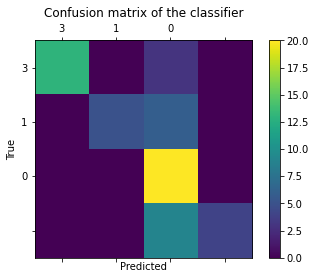

[[13  0  3  0]
 [ 0  5  6  0]
 [ 0  0 20  0]
 [ 0  0  9  4]]


In [21]:
print("faculty: vectorizer: TF-IDF, Classifier:MultinomialNB, \naccuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_mnb, precision_mnb, recall_mnb, f1_mnb))
import pylab as pl
import matplotlib.pyplot as plt
from sklearn import metrics
from warnings import simplefilter #import warning filter
simplefilter(action='ignore', category=FutureWarning) # ignore all future warnings
labels = coventry_rea2['faculty_cat'].unique()
cm = metrics.confusion_matrix(y_test,y_predicted_counts, labels)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier', y=1.08)
fig.colorbar(cax)
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print(cm)

#### LogisticRegression

In [22]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [23]:
y_pred = model.predict(X_test)

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[ 5  7  1  0]
 [ 0 20  0  0]
 [ 0  1 15  0]
 [ 0  2  2  7]]
              precision    recall  f1-score   support

           0       1.00      0.38      0.56        13
           1       0.67      1.00      0.80        20
           2       0.83      0.94      0.88        16
           3       1.00      0.64      0.78        11

    accuracy                           0.78        60
   macro avg       0.88      0.74      0.75        60
weighted avg       0.84      0.78      0.76        60

0.7833333333333333


In [25]:
dump(vectorizer, "preprocessor.joblib")
dump(model, "classifier.joblib")

['classifier.joblib']

In [70]:
preprocessor = load("preprocessor.joblib")
model = load("classifier.joblib")

def predict_topic():
    text = input("Enter text to be predicted: ")
    text = preprocessor.transform([text])
    prediction = model.predict(text)[0]
    dict = {
        'Faculty of Engineering, Environment & Computing':2,
        'Faculty of Health & Life Sciences ':3,
        'Faculty of Business & Law':1,
        'Faculty of Arts & Humanities': 0
    }
    for key,value in dict.items():
        if prediction == value: 
            prediction = key 
            
           
    print("This area is most likely to be in {}." .format(prediction))

In [72]:
predict_topic()

Enter text to be predicted: machine
This area is most likely to be in Faculty of Engineering, Environment & Computing.


##### Count vectorization
Creates a document-term matrix where the entry of each cell will be a count of the number of times that word occurred in that document.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=nltk.corpus.stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()